In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.lines as mlines
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sys import stdout

In [2]:
deriv_num = 1
window_len = 25
poly_or = 5

### Hỗn hợp

In [3]:
honhop_folder = "data2/Honhop"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(honhop_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(honhop_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
honhop = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
honhop.columns = ['_'.join(map(str, col)) for col in honhop.columns]
honhop["File name"] = file_names
honhop["Type"] = honhop["File name"].str.split("-", expand=True)[0].str[0]

### Rễ

In [4]:
re_folder = "data2/Re"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(re_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(re_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
re = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
re.columns = ['_'.join(map(str, col)) for col in re.columns]
re["File name"] = file_names
re["Type"] = re["File name"].str.split("-", expand=True)[0].str[0]

### Thân

In [5]:
than_folder = "data2/Than"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(than_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(than_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
than = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
than.columns = ['_'.join(map(str, col)) for col in than.columns]
than["File name"] = file_names
than["Type"] = than["File name"].str.split("-", expand=True)[0].str[0]

### Test honhop

In [6]:
honhop_folder = "data2/testHonhop"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(honhop_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(honhop_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name + "new")
honhop_test = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
honhop_test.columns = ['_'.join(map(str, col)) for col in honhop_test.columns]
honhop_test["File name"] = file_names
honhop_test["Type"] = honhop_test["File name"].str.split("-", expand=True)[0].str[0]

In [7]:
data = pd.concat([honhop, re, than, honhop_test], axis=0)
data.shape

(159, 1871)

In [8]:
# data["Type"][data["Type"] == "D"] = "R"

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data["Type"])

In [10]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

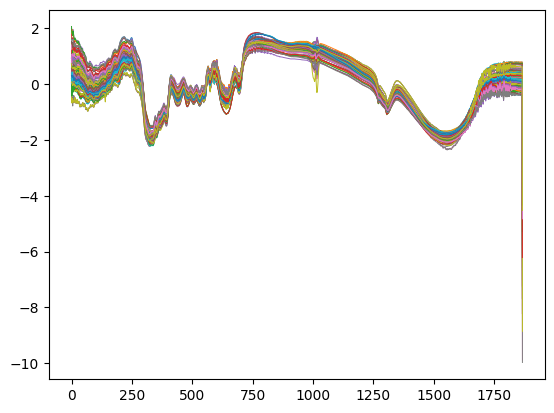

In [11]:
X = data.iloc[:, :-2]
wl = X.columns
X = snv(X.values)
plt.plot(X.T, linewidth = 0.7)
plt.show()

In [12]:
X = savgol_filter(X, window_length = window_len,  polyorder=poly_or, deriv = deriv_num)

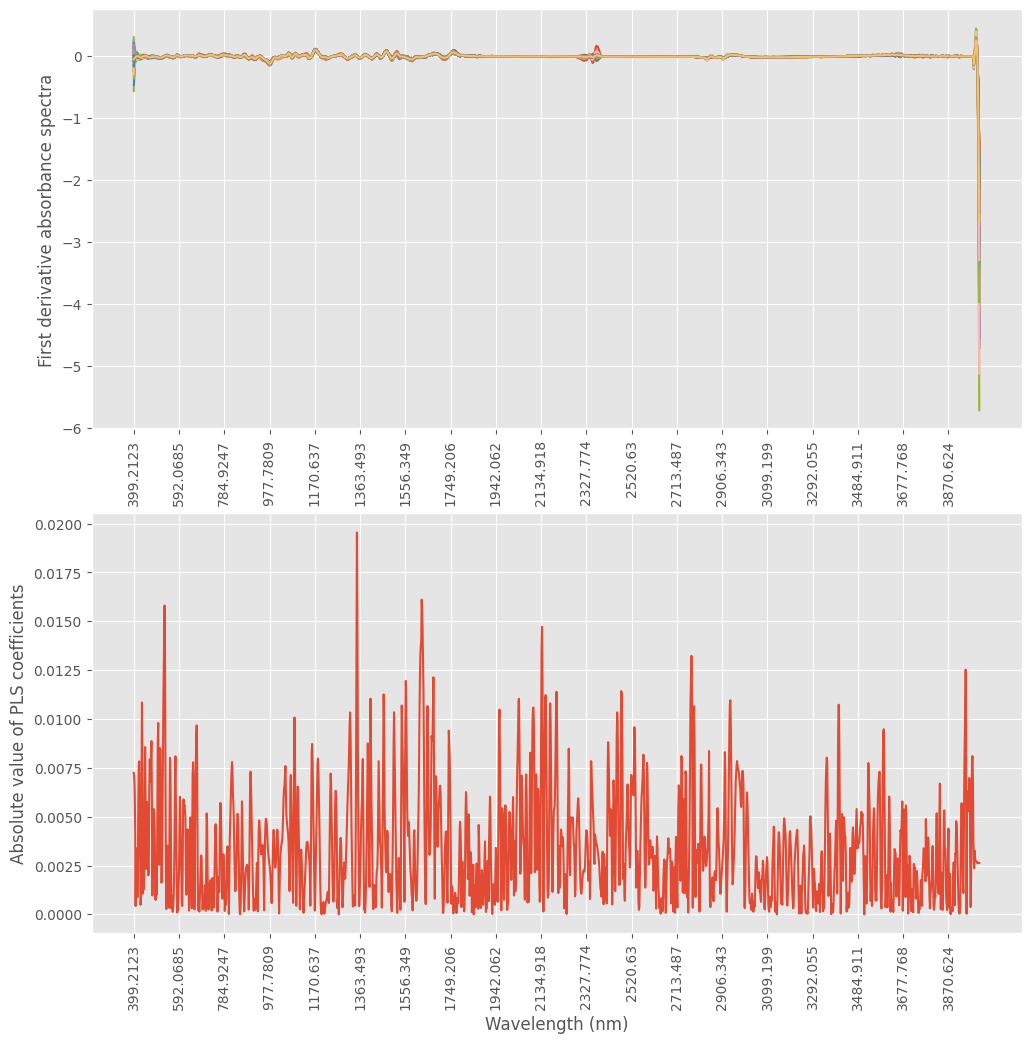

In [13]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pls = PLSRegression(8)
pls.fit(X, y)


# print(np.abs(pls.coef_)reshape(-1,1))
plt.figure(figsize=(12,12))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_).reshape(-1,1))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.gca().set_xticks(np.arange(0, len(wl), 100))
    plt.xticks(rotation=90)
 
    plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [15]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from typing import Union, List, Dict

import numpy as np
from joblib import Parallel, delayed
class SPALDA():
    def __init__(self, 
                 n_features_to_select: int = None,
                 n_cv_folds: int = 5,
                 pls: PLSRegression = None,
                 n_jobs: int = -1):
        self.n_features_to_select = n_features_to_select
        self.lda = LinearDiscriminantAnalysis()
        self.n_cv_folds = n_cv_folds
        self.n_jobs = n_jobs
    
    def fit_spa(self, X, y, seed):
        wavelength_map = np.arange(X.shape[1])
        selected_wave_length = [seed]
        selected_vector = X[:, seed:seed+1]
        remain_wavelength = np.delete(wavelength_map, seed)
        remain_vectors = np.delete(X, seed, 1)

        for i in range(self.n_features_to_select - 1):
            selected_vector = selected_vector / np.linalg.norm(selected_vector, ord = 2)
            orthogonal_vectors = remain_vectors - selected_vector @ np.transpose(np.transpose(remain_vectors) @ selected_vector)
            orthogonal_norms = np.linalg.norm(orthogonal_vectors, ord = 2, axis=0)
            max_length_vector_idx = np.argmax(orthogonal_norms)
            
            selected_wave_length.append(remain_wavelength[max_length_vector_idx])
            wavelength_map = np.delete(wavelength_map, max_length_vector_idx)

            selected_vector = orthogonal_vectors[:, max_length_vector_idx:max_length_vector_idx+1]
            remain_wavelength = np.delete(remain_wavelength, max_length_vector_idx)
            remain_vectors = np.delete(remain_vectors, max_length_vector_idx, 1)
            print("check")
        score = cross_val_score(self.lda, X[:, selected_wave_length], y, cv = self.n_cv_folds)
        loss = 1 - score
        return np.mean(loss), selected_wave_length
    
    def fit(self, X, y):
        candidates = Parallel(n_jobs=self.n_jobs)(delayed(self.fit_spa)(X, y, seed) for seed in range(X.shape[1]))
        print(candidates[0])
        loss, otp_wavelength = min(candidates, key=lambda x: x[0])

        return loss, otp_wavelength
        

In [16]:
spa_lda = SPALDA(40)
mse, otp_wavelength = spa_lda.fit(X, y)
otp_wavelength = sorted(otp_wavelength)

(0.18870967741935485, [0, 1122, 775, 921, 749, 595, 1256, 1838, 155, 1708, 1159, 1413, 211, 358, 1730, 492, 1057, 1590, 1837, 496, 1077, 543, 912, 994, 1214, 999, 1671, 1023, 782, 1863, 1037, 1392, 1230, 804, 56, 1482, 642, 1462, 7, 1447])


In [17]:
X_opt = X[:, otp_wavelength]


In [18]:
X_opt = X[:, otp_wavelength]

lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_opt, y)
# pca = PCA()
# X_lda = pca.fit_transform(X_opt)

In [19]:
import plotly.graph_objects as go


# Create a scatter plot
fig = go.Figure()
hover_text = data["File name"].values
color_map = {
    0: 'orange',
    1: 'blue',
    2: 'red'
}
# Add scatter trace
fig.add_trace(go.Scatter(
    x=X_lda[:, 0],
    y=X_lda[:, 1],
    mode='markers',  # Display markers and text
    marker=dict(
        size=10, 
        color = y,
        colorscale='Viridis', 
        colorbar=dict(title='Type', tickvals = [0,1,2], ticktext = ['Hỗn hợp', 'Rễ', 'Thân']),  
        showscale=True,
        line=dict(
            width=2,  # Width of the border
            color='black'  # Border color
        )
        ),
    hovertemplate = hover_text,

))

# Update layout
fig.update_layout(
    title='2D Scatter Plot Example',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    width = 600,
    height = 600,
)

# Show the plot
fig.show()

In [20]:
test_folder = "data2/Test"
data_frames = []
file_names = []
for index, file_name in enumerate(os.listdir(test_folder)):
    if file_name.endswith(".CSV"):  # Check if the file is a CSV
        file_path = os.path.join(test_folder, file_name)
        df = pd.read_csv(file_path, header=None).values
        if index == 0:
            data_frames.append(df[:, 0].reshape(1, -1))
        data_frames.append(df[:, 1].reshape(1, -1))
        file_names.append(file_name)
test = pd.DataFrame(np.concatenate(data_frames[1:]), columns=list(data_frames[0]))
test.columns = ['_'.join(map(str, col)) for col in test.columns]
test["File name"] = file_names
test["Type"] = test["File name"].str.split("-", expand=True)[0].str[0]

In [21]:
test

,399.2123,401.1409,403.0695,404.998,406.9266,408.8552,410.7837,412.7123,414.6408,416.5694,...,3988.266,3990.195,3992.123,3994.052,3995.98,3997.909,3999.837,4001.766,File name,Type
0,47.91322,44.72962,44.43270,45.82262,45.55671,44.43973,44.72673,45.07159,43.98170,43.47054,...,49.24923,49.24908,49.24609,49.23628,49.27656,49.30932,49.33203,0.0,M1.CSV,M
1,43.01068,41.89880,41.78723,40.79509,39.92355,40.89822,40.52527,40.96305,39.90686,39.59190,...,47.99864,47.99638,48.01379,48.01406,48.04306,48.02804,48.02218,0.0,M2.CSV,M
2,49.31813,49.64507,49.94800,50.10004,49.58234,48.98740,48.90690,49.26768,49.80587,50.03410,...,48.10555,48.17324,48.20655,48.17601,48.18417,48.16763,48.17384,0.0,M3.CSV,M
3,45.79926,46.09223,45.70929,45.70539,45.87705,45.66919,45.83305,46.00776,45.84216,45.48048,...,39.69290,39.74885,39.77573,39.74401,39.74039,39.72898,39.75054,0.0,M4.CSV,M
4,55.87132,55.23475,54.91975,54.81831,54.29011,54.28499,54.51881,54.82055,54.91263,54.36546,...,52.82410,52.85090,52.82244,52.80397,52.86528,52.83565,52.81130,0.0,M5-1.CSV,M
5,56.58463,57.09010,57.04803,57.13952,56.15062,56.13530,56.69629,56.83397,56.65569,56.07261,...,58.05157,58.08049,58.11422,58.11776,58.10531,58.07270,58.05911,0.0,M5-2.CSV,M
6,56.60339,56.23095,56.13525,56.50729,56.20774,56.25411,56.71189,56.77676,56.56879,56.03354,...,57.57919,57.62685,57.59036,57.58477,57.62533,57.59757,57.57706,0.0,M5-3.CSV,M
7,57.16325,56.03078,54.45307,54.10740,53.99395,54.49600,55.84809,55.19974,55.76630,55.88248,...,54.08372,54.09273,54.08028,54.09514,54.10740,54.09743,54.08543,0.0,M5-4.CSV,M
8,57.21651,56.95964,56.52177,55.68295,54.74205,55.08786,55.29156,55.52596,55.62667,55.10399,...,54.11256,54.14736,54.14464,54.15881,54.20229,54.17402,54.15868,0.0,M5-5.CSV,M


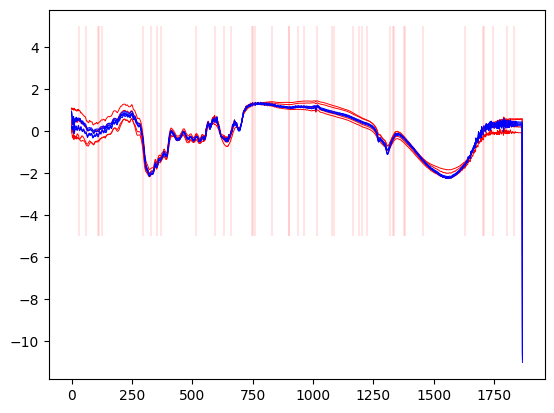

In [22]:
plt.plot(snv(test.iloc[:4, :-2].values).T, color = 'red', linewidth = 0.7)
plt.plot(snv(test.iloc[4:, :-2].values).T, color = 'blue', linewidth = 0.7)
plt.vlines(otp_wavelength, ymin = -5, ymax = 5, colors=['red'], alpha = 0.1)
plt.show()

In [23]:
import plotly.graph_objects as go
import numpy as np

# Create a figure
fig = go.Figure()

# Add a line plot for each spectrum
for i in range(len(test)):
    name = test["File name"][i]
    snv_val = snv(test.iloc[i, :-2].values.reshape(1, -1))
    fig.add_trace(go.Scatter(y=snv_val.ravel(), mode='lines', name=f'{name}', line=dict(width=0.8) ))

for line in otp_wavelength:
    fig.add_shape(
        type='line',
        x0=line, y0=-4,
        x1=line, y1=4,  # Adjust y1 to the maximum y value of your data
        line=dict(color='red', width=2)  # Set opacity for transparency
    )
# Update layout
fig.update_layout(
    title='Spectrum Data with 50 Spectra and 100 Features',
    xaxis_title='Wavelength (nm)',
    yaxis_title='Intensity',
    showlegend=True
)

# Show the plot
fig.show()

In [24]:
X_test = test.iloc[:, :-2]
X_test_snv = snv(X_test.values)
X_test = savgol_filter(X_test_snv, window_length = window_len,  polyorder=poly_or, deriv = deriv_num)

# X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test[:, otp_wavelength]
X_test_lda = lda.transform(X_test_scaled)

In [25]:
import plotly.graph_objects as go


# Create a scatter plot
fig = go.Figure()
hover_text1 = data["File name"].values
hover_text2 = test["File name"].values
color_map = {
    0: 'orange',
    1: 'blue',
    2: 'red'
}
# Add scatter trace
fig.add_trace(go.Scatter(
    x=X_lda[:, 0],
    y=X_lda[:, 1],
    mode='markers',  # Display markers and text
    marker=dict(
        size=10, 
        color = y,
        colorscale='Viridis', 
        colorbar=dict(title='Type', tickvals = [0,1,2], ticktext = ['Hỗn hợp', 'Rễ', 'Thân']),  
        showscale=True,
        line=dict(
            width=2,  # Width of the border
            color='black'  # Border color
        )
        ),
    hovertemplate = hover_text1,

))
fig.add_trace(go.Scatter(
    x=X_test_lda[:, 0],
    y=X_test_lda[:, 1],
    mode='markers + text',  # Display markers and text
    marker=dict(
        size=10, 
        color = 'green',
        line=dict(
            width=2,  # Width of the border
            color='black'  # Border color
        )
        ),
    # hovertemplate = hover_text2,
    text = hover_text2,
    textposition="top right",
    textfont=dict(
        color='red',  # Change the text color
        size=14,      # Change the text size
        family='Arial, sans-serif',  # Change the font family
        # Set the text to bold
        # weight='bold'  
    )

))
fig.update_yaxes(range=[-12, 12])  # Set x-axis limits from 0 to 6
fig.update_xaxes(range=[-24, 24])  # Set y-axis limits from 9 to 15
# Update layout
fig.update_layout(
    title='2D Scatter Plot Example',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    width = 600,
    height = 600,
    showlegend=False
)

# Show the plot
fig.show()

In [26]:
# params = {
#     'wav': wav,
#     'sorted_ind': sorted_ind
# }

In [27]:
### X[:,sorted_ind][:, wav:]

In [28]:
# import pickle 
  
# # Open a file and use dump() 
# with open('file.pkl', 'wb') as file: 
      
#     # A new file will be created 
#     pickle.dump(params, file) 

In [29]:
# plt.plot(opt_Xc.T, linewidth = 0.7)
# plt.show()

In [30]:
# wl_c = [float(i) for i in list(wl)]

In [31]:
# # Get a boolean array according to the indices that are being discarded
# ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])
 
# import matplotlib.collections as collections
 
# # Plot spectra with superimpose selected bands
# fig, ax = plt.subplots(figsize=(8,9))
# with plt.style.context(('ggplot')):
#     ax.plot(wl, X.T)
#     plt.ylabel('First derivative absorbance spectra')
#     plt.xlabel('Wavelength (nm)')
 
# collection = collections.BrokenBarHCollection.span_where(
#     wl_c, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
# ax.add_collection(collection)
 
# plt.show()

In [32]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(opt_Xc)

# # save
# with open('scaler.pkl','wb') as f:
#     pickle.dump(scaler,f)

In [33]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda = LinearDiscriminantAnalysis()
# X_lda = lda.fit_transform(scaled_data, y)

In [34]:
# # save
# with open('model.pkl','wb') as f:
#     pickle.dump(lda,f)

In [35]:
# import plotly.graph_objects as go


# # Create a scatter plot
# fig = go.Figure()
# hover_text = data["File name"].values
# color_map = {
#     0: 'orange',
#     1: 'blue',
#     2: 'red'
# }
# # Add scatter trace
# fig.add_trace(go.Scatter(
#     x=X_lda[:, 0],
#     y=X_lda[:, 1],
#     mode='markers',  # Display markers and text
#     marker=dict(
#         size=10, 
#         color = y,
#         colorscale='Viridis', 
#         colorbar=dict(title='Type', tickvals = [0,1,2], ticktext = ['Hỗn hợp', 'Rễ', 'Thân']),  
#         showscale=True,
#         line=dict(
#             width=2,  # Width of the border
#             color='black'  # Border color
#         )
#         ),
#     hovertemplate = hover_text,

# ))

# # Update layout
# fig.update_layout(
#     title='2D Scatter Plot Example',
#     xaxis_title='X Axis',
#     yaxis_title='Y Axis',
#     width = 600,
#     height = 600,
# )

# # Show the plot
# fig.show()

In [36]:
# # Open the file in binary mode 
# with open('file.pkl', 'rb') as file: 
      
#     # Call load method to deserialze 
#     params = pickle.load(file) 
  
#     print(params) 

In [37]:
# sorted_ind = params['sorted_ind']
# wav = params['wav']
# X_new = X[:,sorted_ind][:, wav:]

In [38]:
# # load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)
# with open('scaler.pkl', 'rb') as f:
#     scale = pickle.load(f)

# X_scaled = scale.transform(X_new)
# print(X_scaled)
# clf2.predict(X_scaled)